In [1]:
from birdclef.utils import get_spark
import pyspark.sql.functions as F

In [2]:
spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/30 19:24:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet(
    "../../data/processed/birdclef-2023/train_embeddings_consolidated_v2_sample"
)
df.show(n=5)

+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|species|track_stem|track_type|          track_name|           embedding|         predictions|start_time|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|abhori1|  XC737347|   source2|abhori1/XC737347_...|[-9.7301635742187...|[{0, 1815, Milvag...|       195|
|abhori1|  XC513159|   source0|abhori1/XC513159_...|[-13.383581161499...|[{0, 1847, Moloth...|        54|
|abhori1|  XC513159|   source1|abhori1/XC513159_...|[-5.6110315322875...|[{0, 2975, Syrigm...|       111|
|abhori1|  XC611614|   source0|abhori1/XC611614_...|[-8.1713380813598...|[{0, 1565, Lanius...|        78|
|abhori1|  XC513159|   source0|abhori1/XC513159_...|[-15.172685623168...|[{0, 2156, Passer...|        69|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



Extract embeddings from source track only

In [4]:
source = df.filter(df["track_type"] == "")
source.show()

+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|species|track_stem|track_type|          track_name|           embedding|         predictions|start_time|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|abhori1|  XC641917|          |abhori1/XC641917.mp3|[-11.481126785278...|[{0, 2205, Periso...|        72|
|abhori1|  XC611614|          |abhori1/XC611614.mp3|[-15.695769309997...|[{0, 2076, Oriolu...|         3|
|abhori1|  XC398787|          |abhori1/XC398787.mp3|[-13.638436317443...|[{0, 2076, Oriolu...|        39|
|abhori1|  XC737347|          |abhori1/XC737347.mp3|[-19.533819198608...|[{0, 2076, Oriolu...|        84|
|abhori1|  XC737347|          |abhori1/XC737347.mp3|[-19.749326705932...|[{0, 2076, Oriolu...|       189|
|abhori1|  XC398787|          |abhori1/XC398787.mp3|[-11.859894752502...|[{0, 2076, Oriolu...|         0|
|abhori1|  XC737347|          |abhori1/XC73734

Exploded predictions

In [5]:
print(source.select(source.track_name).take(1)[0])

source.select(source.predictions).take(1)[0]["predictions"]

Row(track_name='abhori1/XC641917.mp3')


[Row(rank=0, index=2205, label='Perisoreus infaustus_Siberian Jay', mapped_label='sibjay1', probability=0.003058952046558261),
 Row(rank=1, index=2076, label='Oriolus larvatus_African Black-headed Oriole', mapped_label='abhori1', probability=0.0022603634279221296),
 Row(rank=2, index=3012, label='Telophorus zeylonus_Bokmakierie', mapped_label='bokmak1', probability=0.0014614507090300322),
 Row(rank=3, index=2077, label='Oriolus oriolus_Eurasian Golden Oriole', mapped_label='eugori2', probability=0.0011656048009172082),
 Row(rank=4, index=2079, label='Oriolus traillii_Maroon Oriole', mapped_label='marori2', probability=0.000852204451803118),
 Row(rank=5, index=2081, label='Oriolus xanthornus_Black-hooded Oriole', mapped_label='blhori1', probability=0.0008248982485383749),
 Row(rank=6, index=2073, label='Oriolus chinensis_Black-naped Oriole', mapped_label='blnori1', probability=0.0003854174865409732),
 Row(rank=7, index=2072, label='Oriolus brachyrynchus_Western Black-headed Oriole', map

In [6]:
explode_preds = source.select(
    "species",
    "track_stem",
    "track_name",
    "embedding",
    "start_time",
    F.explode(source.predictions).alias("col"),
)
explode_preds = explode_preds.select(
    "species",
    "track_stem",
    "track_name",
    "embedding",
    "start_time",
    explode_preds.col.label.alias("label"),
    explode_preds.col.mapped_label.alias("mapped_label"),
    explode_preds.col.probability.alias("probability"),
)
explode_preds.show()

# temp = source.select(source.track_name, f.explode(source.predictions))
# temp = temp.select(temp.track_name, temp.col["label"].alias("label"), temp.col["mapped_label"].alias("mapped_label"),
#                    temp.col["probability"].alias("probability"))
# temp.show()
# source.show()

+-------+----------+--------------------+--------------------+----------+--------------------+------------+--------------------+
|species|track_stem|          track_name|           embedding|start_time|               label|mapped_label|         probability|
+-------+----------+--------------------+--------------------+----------+--------------------+------------+--------------------+
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Perisoreus infaus...|     sibjay1|0.003058952046558261|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Oriolus larvatus_...|     abhori1|0.002260363427922...|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Telophorus zeylon...|     bokmak1|0.001461450709030...|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Oriolus oriolus_E...|     eugori2|0.001165604800917...|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Oriolus traillii_...|   

Sigmoid

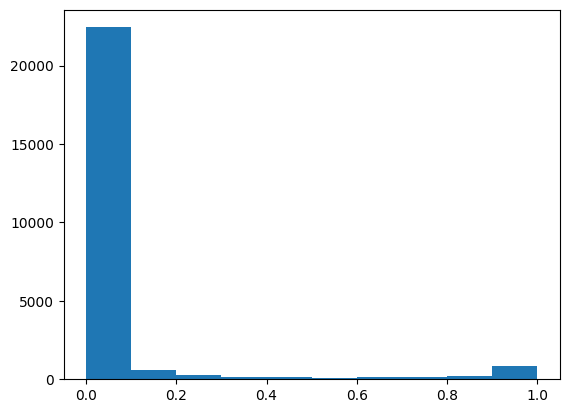

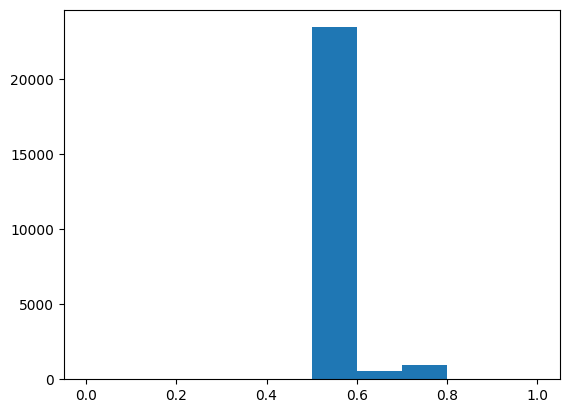

In [7]:
import matplotlib.pyplot as plt

explode_preds_sig = explode_preds.select(
    "species",
    "track_stem",
    "track_name",
    "embedding",
    "start_time",
    "label",
    "mapped_label",
    (1 / (1 + F.exp(-1 * explode_preds.probability))).alias("probability"),
)
probs_no_sig = [x["probability"] for x in explode_preds.select("probability").collect()]
plt.hist(probs_no_sig)
plt.show()
probs = [x["probability"] for x in explode_preds_sig.select("probability").collect()]
x_axis = [i / 10 for i in range(10)]
plt.hist(probs, range=[0, 1])
plt.show()

Taking species with prob > 0.5

In [8]:
explode_preds_bird_calls = explode_preds.filter(explode_preds["probability"] >= 0.5)
explode_preds_bird_calls.show()
print(explode_preds_bird_calls.count())

+-------+----------+--------------------+--------------------+----------+--------------------+------------+------------------+
|species|track_stem|          track_name|           embedding|start_time|               label|mapped_label|       probability|
+-------+----------+--------------------+--------------------+----------+--------------------+------------+------------------+
|abhori1|  XC611614|abhori1/XC611614.mp3|[-15.695769309997...|         3|Oriolus larvatus_...|     abhori1|0.9318422675132751|
|abhori1|  XC737347|abhori1/XC737347.mp3|[-19.533819198608...|        84|Oriolus larvatus_...|     abhori1|0.5274410843849182|
|abhori1|  XC737347|abhori1/XC737347.mp3|[-19.749326705932...|       189|Oriolus larvatus_...|     abhori1|0.8413838744163513|
|abhori1|  XC737347|abhori1/XC737347.mp3|[-21.518583297729...|        75|Oriolus larvatus_...|     abhori1|0.7677854895591736|
|abhori1|  XC611614|abhori1/XC611614.mp3|[-15.915067672729...|        30|Oriolus larvatus_...|     abhori1|0.99

parsing species name

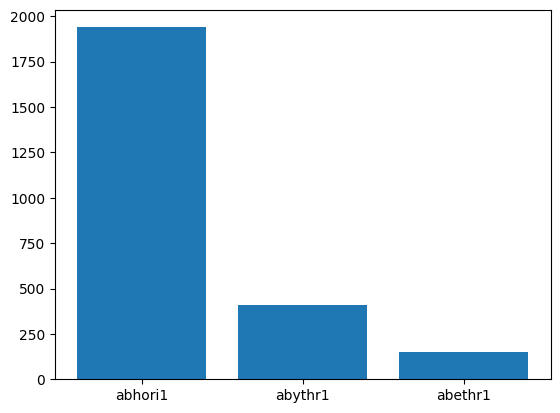

In [9]:
species = [s["species"] for s in source.select("species").collect()]
species_count = dict()
for s in species:
    species_count[s] = species_count.get(s, 0) + 1
plt.bar(list(species_count.keys()), list(species_count.values()))
plt.show()

final dataset

In [10]:
data = explode_preds_bird_calls.select(
    ["species", "probability"]
    + [
        explode_preds_bird_calls.embedding[i].alias("embedding" + str(i))
        for i in range(3337)
    ]
)
data = data.toPandas()
data.head()

23/04/30 19:24:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,species,probability,embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,...,embedding3327,embedding3328,embedding3329,embedding3330,embedding3331,embedding3332,embedding3333,embedding3334,embedding3335,embedding3336
0,abhori1,0.931842,-15.695769,-14.175133,-14.107721,-15.785131,-15.412916,-14.258154,-16.648735,-17.852036,...,-13.420475,-14.661019,-12.913609,-12.781441,-11.813440,-16.250906,-12.645384,-13.045488,-12.198296,-15.637187
1,abhori1,0.527441,-19.533819,-16.186634,-12.176779,-11.817211,-15.650982,-14.040951,-14.823906,-16.595118,...,-12.638477,-15.555634,-15.871542,-12.380343,-9.460049,-14.972944,-14.483743,-9.331749,-12.910712,-11.881019
2,abhori1,0.841384,-19.749327,-15.550808,-11.639582,-12.933417,-18.489109,-17.498230,-17.191210,-17.753681,...,-14.857538,-16.427847,-15.909166,-11.827403,-13.136386,-17.146564,-15.114254,-10.958441,-14.703631,-13.515043
3,abhori1,0.767785,-21.518583,-18.931110,-13.217918,-11.979479,-14.901256,-15.360685,-17.736120,-15.968261,...,-14.281636,-15.552175,-16.286346,-12.225875,-13.201905,-16.558741,-14.998167,-12.965591,-14.886533,-13.775451
4,abhori1,0.992275,-15.915068,-13.532173,-13.717117,-11.389903,-12.852736,-11.249538,-14.087188,-13.257503,...,-13.322052,-12.597613,-10.335143,-13.245964,-11.704409,-15.318541,-14.019773,-10.212161,-11.268396,-11.581400


classifier?

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_x, test_x, train_y, test_y = train_test_split(
    data.loc[:, data.columns != "species"],
    data["species"],
    test_size=0.25,
    stratify=data["species"],
)


def eval(truth, preds):
    print("Accuracy:", accuracy_score(truth, preds))
    print(
        "Precision:",
        precision_score(truth, preds, average=None),
        precision_score(truth, preds, average="macro"),
    )
    print(
        "Recall:",
        recall_score(truth, preds, average=None),
        precision_score(truth, preds, average="macro"),
    )
    print(
        "F1 Score:",
        f1_score(truth, preds, average=None),
        precision_score(truth, preds, average="macro"),
    )

In [12]:
from sklearn.tree import DecisionTreeClassifier

treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(train_x, train_y)
preds = treeClassifier.predict(test_x)

eval(test_y, preds)

Accuracy: 0.9744318181818182
Precision: [0.375      0.99673203 0.92105263] 0.7642615525742461
Recall: [0.75       0.9807074  0.94594595] 0.7642615525742461
F1 Score: [0.5        0.98865478 0.93333333] 0.7642615525742461


In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
preds = knn.predict(test_x)

eval(test_y, preds)

Accuracy: 0.9886363636363636
Precision: [0.66666667 0.99679487 0.94594595] 0.8698024948024948
Recall: [0.5        1.         0.94594595] 0.8698024948024948
F1 Score: [0.57142857 0.99839486 0.94594595] 0.8698024948024948


In [14]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000)
log.fit(train_x, train_y)
preds = log.predict(test_x)

eval(test_y, preds)

Accuracy: 0.9914772727272727
Precision: [1.         0.99677419 0.94736842] 0.9813808715336729
Recall: [1.         0.99356913 0.97297297] 0.9813808715336729
F1 Score: [1.         0.99516908 0.96      ] 0.9813808715336729


In [15]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_y)

xgbc = XGBClassifier()
xgbc.fit(train_x, le.transform(train_y))
preds = xgbc.predict(test_x)

eval(le.transform(test_y), preds)

Accuracy: 0.9829545454545454
Precision: [0.5        0.99356913 0.94594595] 0.8131716925929146
Recall: [0.5        0.99356913 0.94594595] 0.8131716925929146
F1 Score: [0.5        0.99356913 0.94594595] 0.8131716925929146


In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [50, 100],
    "max_depth": [3, 4],
    "gamma": [1.5, 2],
    "min_child_weight": [1, 5, 10],
}

search = GridSearchCV(
    estimator=xgbc, param_grid=params, scoring="precision_macro", n_jobs=-1, cv=2
)
search.fit(train_x, le.transform(train_y))
print(search.best_params_)
preds = search.predict(test_x)

eval(le.transform(test_y), preds)

/home/nzhon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nzhon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nzhon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nzhon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification

{'gamma': 2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50}
Accuracy: 0.9801136363636364
Precision: [0.33333333 0.99356913 0.92105263] 0.7493183655816926
Recall: [0.25       0.99356913 0.94594595] 0.7493183655816926
F1 Score: [0.28571429 0.99356913 0.93333333] 0.7493183655816926
